<a href="https://colab.research.google.com/github/DevZIKIII/RNN/blob/main/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

=== RNN para Previsão de Temperatura ===

1. Gerando dados de temperatura...
Dados gerados: 730 dias
Temperatura média: 25.7°C
Temperatura mínima: 9.2°C
Temperatura máxima: 41.4°C



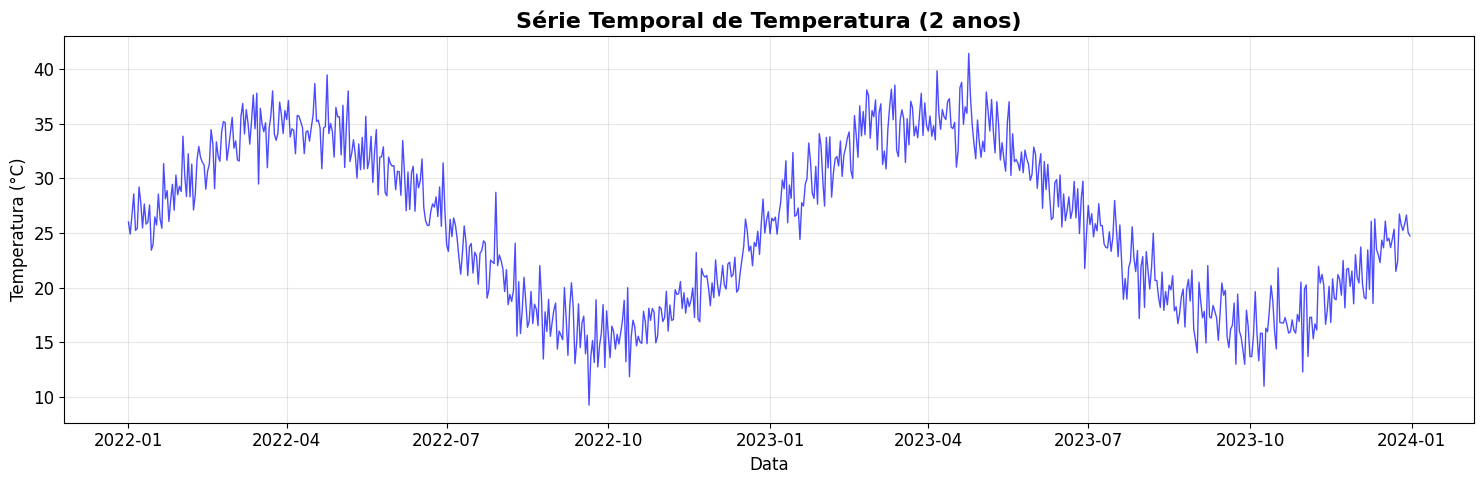

2. Preparando dados para a RNN...
Sequências criadas com 30 dias de histórico
Dados de treino: 560 amostras
Dados de teste: 140 amostras

3. Construindo e treinando a RNN...
Treinando modelo SimpleRNN...

4. Construindo modelo LSTM para comparação...
Treinando modelo LSTM...

5. Avaliando modelos...

Resultados SimpleRNN:
  MAE: 1.96°C
  RMSE: 2.48°C

Resultados LSTM:
  MAE: 1.85°C
  RMSE: 2.32°C


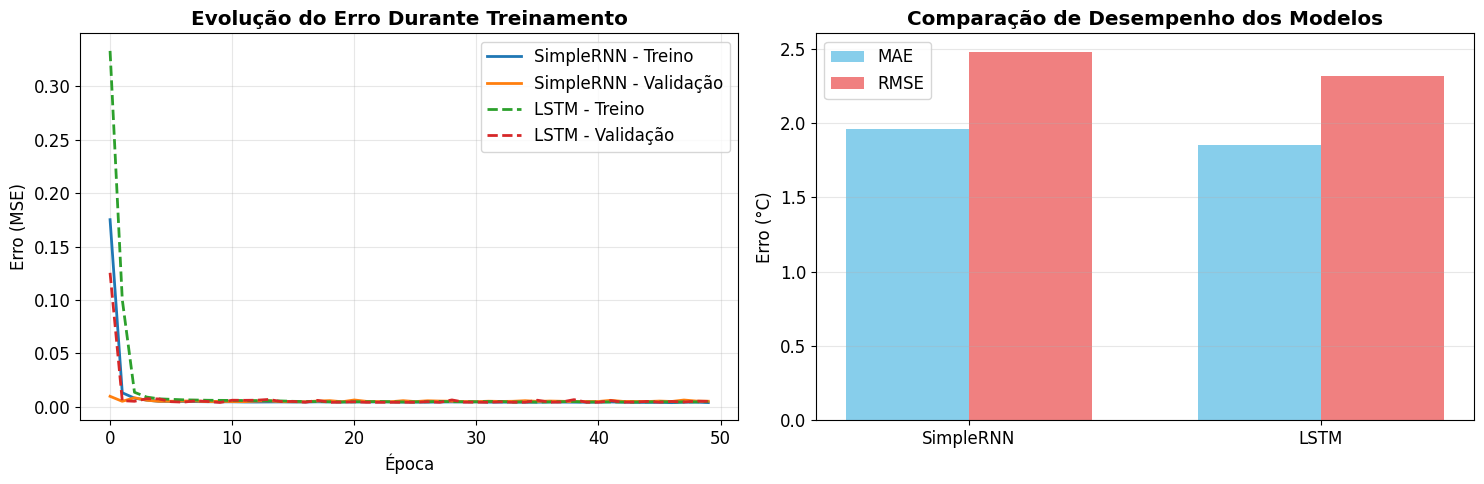

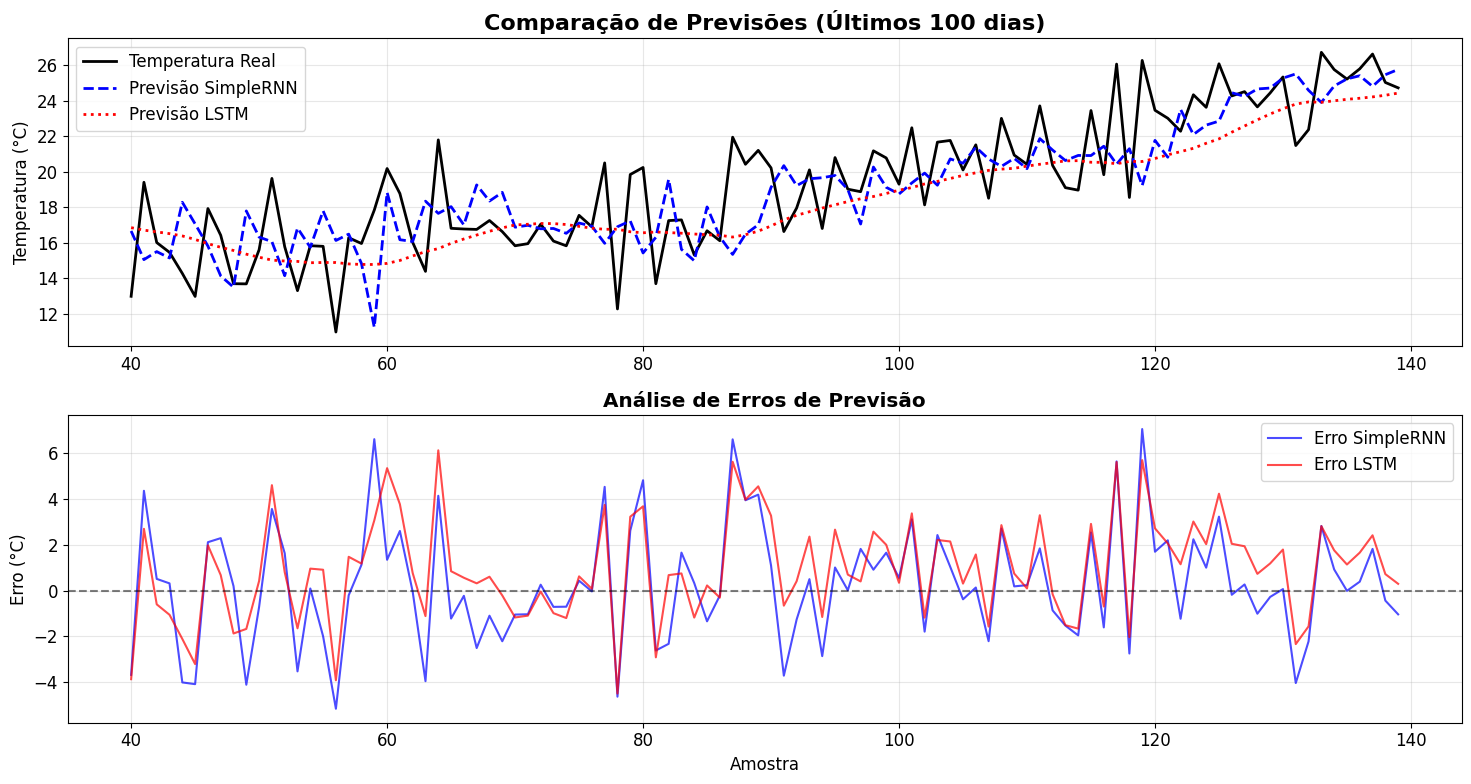


6. Fazendo previsões para os próximos 30 dias...


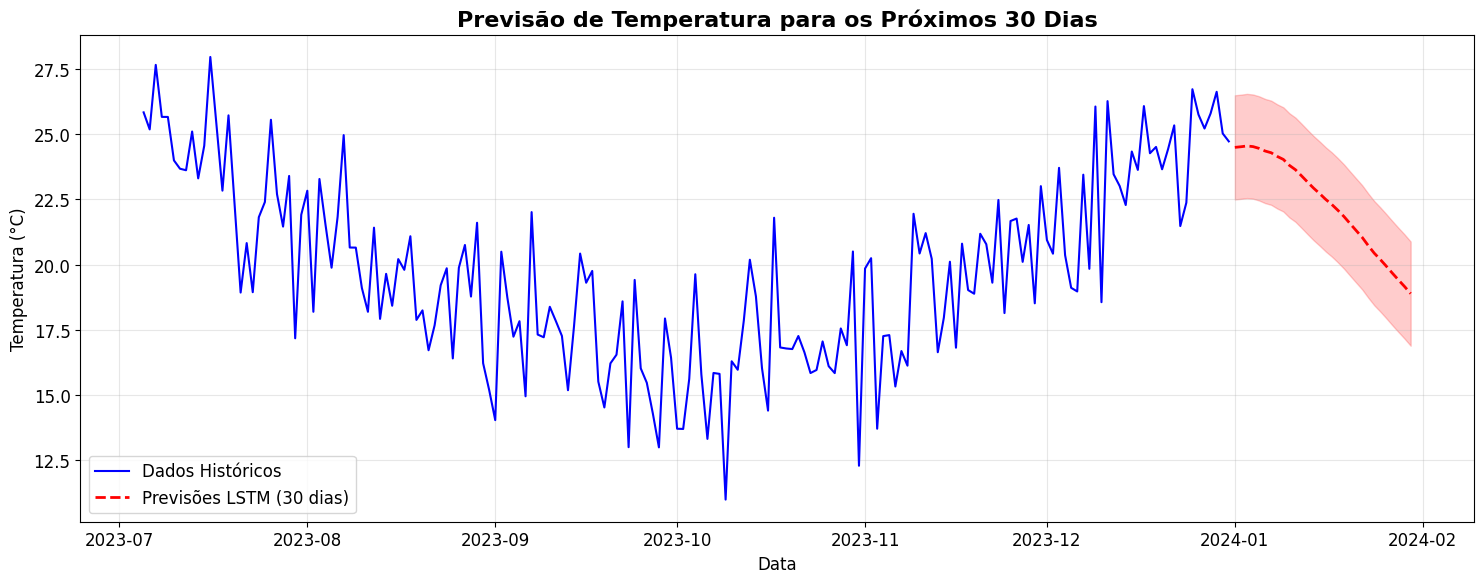


=== Análise Completa ===
A RNN SimpleRNN obteve MAE de 1.96°C
A LSTM (RNN avançada) obteve MAE de 1.85°C
Melhoria da LSTM sobre RNN simples: 5.6%

Temperatura média prevista para próximos 30 dias: 22.3°C
Temperatura mínima prevista: 18.9°C
Temperatura máxima prevista: 24.6°C

✓ Demonstração completa da RNN finalizada!
  - Dados sintéticos gerados
  - Modelos treinados e comparados
  - Previsões futuras realizadas
  - Gráficos gerados para apresentação


In [1]:
"""
Sistema de Previsão de Temperatura usando Redes Neurais Recorrentes (RNN)
========================================================================

Autor: Sistema de demonstração RNN
Data: 2024
Versão: 1.0

Descrição:
---------
Este sistema implementa e compara duas arquiteturas de RNN para previsão
de séries temporais de temperatura: SimpleRNN e LSTM. O objetivo é demonstrar
como RNNs capturam padrões temporais e fazem previsões futuras.

Componentes principais:
---------------------
1. Geração de dados sintéticos com padrões sazonais
2. Preparação e normalização de dados
3. Implementação de SimpleRNN
4. Implementação de LSTM
5. Comparação de desempenho
6. Visualização de resultados
7. Previsão futura (30 dias)

Dependências:
------------
- numpy: Operações numéricas
- pandas: Manipulação de dados temporais
- matplotlib: Visualizações
- tensorflow: Construção de redes neurais
- sklearn: Pré-processamento de dados
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, LSTM
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

# Configuração para gráficos em português
plt.rcParams['font.size'] = 12

print("=== RNN para Previsão de Temperatura ===\n")

# ==============================================================================
# ETAPA 1: GERAÇÃO DE DADOS SINTÉTICOS DE TEMPERATURA
# ==============================================================================
print("1. Gerando dados de temperatura...")
np.random.seed(42)  # Seed para reprodutibilidade

# Parâmetros de simulação
dias = 365 * 2  # 2 anos de dados (730 dias)
tempo = np.arange(dias)

# Componente 1: Padrão sazonal (simula verão/inverno)
# - Usa função seno para criar oscilação anual
# - Amplitude de 10°C (±10 da média)
# - Média base de 25°C
sazonal = 10 * np.sin(2 * np.pi * tempo / 365) + 25

# Componente 2: Tendência de aquecimento global
# - Aumento gradual de 0.002°C por dia
# - Simula mudanças climáticas de longo prazo
tendencia = 0.002 * tempo

# Componente 3: Variabilidade diária (ruído)
# - Distribuição normal com desvio padrão de 2°C
# - Simula flutuações meteorológicas diárias
ruido = np.random.normal(0, 2, dias)

# Combinação dos três componentes
temperatura = sazonal + tendencia + ruido

# Criar DataFrame
df = pd.DataFrame({
    'dia': pd.date_range('2022-01-01', periods=dias, freq='D'),
    'temperatura': temperatura
})

print(f"Dados gerados: {len(df)} dias")
print(f"Temperatura média: {df['temperatura'].mean():.1f}°C")
print(f"Temperatura mínima: {df['temperatura'].min():.1f}°C")
print(f"Temperatura máxima: {df['temperatura'].max():.1f}°C\n")

# 2. VISUALIZAÇÃO DOS DADOS ORIGINAIS
plt.figure(figsize=(15, 5))
plt.plot(df['dia'], df['temperatura'], 'b-', alpha=0.7, linewidth=1)
plt.title('Série Temporal de Temperatura (2 anos)', fontsize=16, fontweight='bold')
plt.xlabel('Data')
plt.ylabel('Temperatura (°C)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ==============================================================================
# ETAPA 3: PREPARAÇÃO DOS DADOS PARA A RNN
# ==============================================================================
print("2. Preparando dados para a RNN...")

# Normalização dos dados (crítico para RNNs)
# - Transforma valores para intervalo [0,1]
# - Melhora convergência do treinamento
# - Evita problemas com gradientes
scaler = MinMaxScaler(feature_range=(0, 1))
temperatura_normalizada = scaler.fit_transform(df['temperatura'].values.reshape(-1, 1))

def criar_sequencias(dados, n_passos):
    """
    Cria sequências de entrada/saída para treinar a RNN.

    Parâmetros:
    -----------
    dados : array
        Dados normalizados de temperatura
    n_passos : int
        Número de dias usados para prever o próximo

    Retorna:
    --------
    X : array de shape (n_amostras, n_passos, 1)
        Sequências de entrada (histórico)
    y : array de shape (n_amostras, 1)
        Valores alvo (próximo dia)

    Exemplo:
    --------
    Se n_passos=3 e dados=[1,2,3,4,5]:
    X = [[1,2,3], [2,3,4]]
    y = [4, 5]
    """
    X, y = [], []
    for i in range(len(dados) - n_passos):
        X.append(dados[i:i + n_passos])
        y.append(dados[i + n_passos])
    return np.array(X), np.array(y)

# Criar sequências (usar últimos 30 dias para prever próximo dia)
n_passos = 30
X, y = criar_sequencias(temperatura_normalizada, n_passos)

# Dividir em treino e teste (80/20)
split = int(0.8 * len(X))
X_treino, X_teste = X[:split], X[split:]
y_treino, y_teste = y[:split], y[split:]

print(f"Sequências criadas com {n_passos} dias de histórico")
print(f"Dados de treino: {len(X_treino)} amostras")
print(f"Dados de teste: {len(X_teste)} amostras\n")

# ==============================================================================
# ETAPA 4: CONSTRUÇÃO DO MODELO SIMPLE RNN
# ==============================================================================
print("3. Construindo e treinando a RNN...")

# Arquitetura do modelo SimpleRNN:
#
# Entrada (30,1) → SimpleRNN(50) → SimpleRNN(50) → Dense(25) → Dense(1) → Saída
#
# Camadas:
# --------
# 1. SimpleRNN(50): Primeira camada recorrente com 50 neurônios
#    - return_sequences=True: Retorna sequência completa para próxima RNN
#    - activation='relu': Função de ativação ReLU
#
# 2. SimpleRNN(50): Segunda camada recorrente
#    - Processa a sequência da primeira camada
#    - Retorna apenas última saída
#
# 3. Dense(25): Camada totalmente conectada
#    - Reduz dimensionalidade
#    - Adiciona não-linearidade
#
# 4. Dense(1): Camada de saída
#    - Produz previsão de temperatura

modelo_rnn = Sequential([
    SimpleRNN(50, activation='relu', return_sequences=True, input_shape=(n_passos, 1)),
    SimpleRNN(50, activation='relu'),
    Dense(25, activation='relu'),
    Dense(1)
])

# Configuração do treinamento
# - Otimizador Adam: Taxa de aprendizado adaptativa
# - Loss MSE: Erro quadrático médio (padrão para regressão)
# - Métrica MAE: Erro absoluto médio (interpretável em °C)
modelo_rnn.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Treinar modelo
print("Treinando modelo SimpleRNN...")
historico_rnn = modelo_rnn.fit(
    X_treino, y_treino,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=0
)

# ==============================================================================
# ETAPA 5: COMPARAÇÃO COM LSTM (LONG SHORT-TERM MEMORY)
# ==============================================================================
print("\n4. Construindo modelo LSTM para comparação...")

# LSTM: Evolução da RNN simples
#
# Vantagens sobre SimpleRNN:
# ------------------------
# 1. Portões de esquecimento: Decide o que esquecer
# 2. Portões de entrada: Decide o que armazenar
# 3. Portões de saída: Decide o que outputar
# 4. Estado de célula: Memória de longo prazo
#
# Isso resolve o problema de "vanishing gradient" das RNNs simples,
# permitindo que a rede aprenda dependências de longo prazo.

modelo_lstm = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(n_passos, 1)),
    LSTM(50, activation='relu'),
    Dense(25, activation='relu'),
    Dense(1)
])

modelo_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

print("Treinando modelo LSTM...")
historico_lstm = modelo_lstm.fit(
    X_treino, y_treino,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=0
)

# 6. AVALIAÇÃO DOS MODELOS
print("\n5. Avaliando modelos...")

# Fazer previsões
previsoes_rnn = modelo_rnn.predict(X_teste, verbose=0)
previsoes_lstm = modelo_lstm.predict(X_teste, verbose=0)

# Desnormalizar previsões
previsoes_rnn = scaler.inverse_transform(previsoes_rnn)
previsoes_lstm = scaler.inverse_transform(previsoes_lstm)
y_teste_real = scaler.inverse_transform(y_teste)

# Calcular métricas
from sklearn.metrics import mean_squared_error, mean_absolute_error

mae_rnn = mean_absolute_error(y_teste_real, previsoes_rnn)
mae_lstm = mean_absolute_error(y_teste_real, previsoes_lstm)
rmse_rnn = np.sqrt(mean_squared_error(y_teste_real, previsoes_rnn))
rmse_lstm = np.sqrt(mean_squared_error(y_teste_real, previsoes_lstm))

print(f"\nResultados SimpleRNN:")
print(f"  MAE: {mae_rnn:.2f}°C")
print(f"  RMSE: {rmse_rnn:.2f}°C")

print(f"\nResultados LSTM:")
print(f"  MAE: {mae_lstm:.2f}°C")
print(f"  RMSE: {rmse_lstm:.2f}°C")

# 7. VISUALIZAÇÃO DOS RESULTADOS
# Gráfico 1: Histórico de Treinamento
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(historico_rnn.history['loss'], label='SimpleRNN - Treino', linewidth=2)
ax1.plot(historico_rnn.history['val_loss'], label='SimpleRNN - Validação', linewidth=2)
ax1.plot(historico_lstm.history['loss'], label='LSTM - Treino', linestyle='--', linewidth=2)
ax1.plot(historico_lstm.history['val_loss'], label='LSTM - Validação', linestyle='--', linewidth=2)
ax1.set_title('Evolução do Erro Durante Treinamento', fontweight='bold')
ax1.set_xlabel('Época')
ax1.set_ylabel('Erro (MSE)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Gráfico 2: Comparação de Métricas
modelos = ['SimpleRNN', 'LSTM']
mae_valores = [mae_rnn, mae_lstm]
rmse_valores = [rmse_rnn, rmse_lstm]

x = np.arange(len(modelos))
largura = 0.35

ax2.bar(x - largura/2, mae_valores, largura, label='MAE', color='skyblue')
ax2.bar(x + largura/2, rmse_valores, largura, label='RMSE', color='lightcoral')
ax2.set_title('Comparação de Desempenho dos Modelos', fontweight='bold')
ax2.set_ylabel('Erro (°C)')
ax2.set_xticks(x)
ax2.set_xticklabels(modelos)
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Gráfico 3: Previsões vs Valores Reais
plt.figure(figsize=(15, 8))

# Selecionar últimos 100 pontos para melhor visualização
n_pontos = 100
indices = range(len(y_teste_real) - n_pontos, len(y_teste_real))

plt.subplot(2, 1, 1)
plt.plot(indices, y_teste_real[-n_pontos:], 'k-', label='Temperatura Real', linewidth=2)
plt.plot(indices, previsoes_rnn[-n_pontos:], 'b--', label='Previsão SimpleRNN', linewidth=2)
plt.plot(indices, previsoes_lstm[-n_pontos:], 'r:', label='Previsão LSTM', linewidth=2)
plt.title('Comparação de Previsões (Últimos 100 dias)', fontsize=16, fontweight='bold')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
erro_rnn = y_teste_real[-n_pontos:] - previsoes_rnn[-n_pontos:]
erro_lstm = y_teste_real[-n_pontos:] - previsoes_lstm[-n_pontos:]
plt.plot(indices, erro_rnn, 'b-', label='Erro SimpleRNN', alpha=0.7)
plt.plot(indices, erro_lstm, 'r-', label='Erro LSTM', alpha=0.7)
plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)
plt.title('Análise de Erros de Previsão', fontweight='bold')
plt.xlabel('Amostra')
plt.ylabel('Erro (°C)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ==============================================================================
# ETAPA 8: PREVISÃO FUTURA (MODO RECURSIVO)
# ==============================================================================
print("\n6. Fazendo previsões para os próximos 30 dias...")

# Estratégia de previsão recursiva:
# 1. Usar últimos 30 dias reais como entrada inicial
# 2. Prever dia 31
# 3. Adicionar previsão à sequência, remover dia 1
# 4. Prever dia 32 usando dias 2-31
# 5. Repetir processo para 30 dias

ultima_sequencia = temperatura_normalizada[-n_passos:]
previsoes_futuras = []

# Loop de previsão recursiva
sequencia_atual = ultima_sequencia.copy()
for i in range(30):
    # Preparar entrada no formato correto (batch_size=1, timesteps=30, features=1)
    entrada = sequencia_atual.reshape(1, n_passos, 1)

    # Fazer previsão para próximo dia
    proxima_previsao = modelo_lstm.predict(entrada, verbose=0)
    previsoes_futuras.append(proxima_previsao[0, 0])

    # Atualizar sequência: remove primeiro dia, adiciona previsão
    # Isso simula o avanço temporal
    sequencia_atual = np.append(sequencia_atual[1:], proxima_previsao)

# Desnormalizar previsões futuras
previsoes_futuras = scaler.inverse_transform(np.array(previsoes_futuras).reshape(-1, 1))

# Criar datas futuras
datas_futuras = pd.date_range(df['dia'].iloc[-1] + pd.Timedelta(days=1), periods=30, freq='D')

# Gráfico final: Série completa com previsões futuras
plt.figure(figsize=(15, 6))

# Dados históricos
plt.plot(df['dia'][-180:], df['temperatura'][-180:], 'b-', label='Dados Históricos', linewidth=1.5)

# Previsões futuras
plt.plot(datas_futuras, previsoes_futuras, 'r--', label='Previsões LSTM (30 dias)', linewidth=2)
plt.fill_between(datas_futuras,
                 previsoes_futuras.flatten() - 2,  # Intervalo de confiança aproximado
                 previsoes_futuras.flatten() + 2,
                 color='red', alpha=0.2)

plt.title('Previsão de Temperatura para os Próximos 30 Dias', fontsize=16, fontweight='bold')
plt.xlabel('Data')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n=== Análise Completa ===")
print(f"A RNN SimpleRNN obteve MAE de {mae_rnn:.2f}°C")
print(f"A LSTM (RNN avançada) obteve MAE de {mae_lstm:.2f}°C")
print(f"Melhoria da LSTM sobre RNN simples: {((mae_rnn - mae_lstm) / mae_rnn * 100):.1f}%")
print(f"\nTemperatura média prevista para próximos 30 dias: {previsoes_futuras.mean():.1f}°C")
print(f"Temperatura mínima prevista: {previsoes_futuras.min():.1f}°C")
print(f"Temperatura máxima prevista: {previsoes_futuras.max():.1f}°C")

print("\n✓ Demonstração completa da RNN finalizada!")
print("  - Dados sintéticos gerados")
print("  - Modelos treinados e comparados")
print("  - Previsões futuras realizadas")
print("  - Gráficos gerados para apresentação")